## HW 4
### Text Analysis and Neural Networks
Gian Zlupko 

#### Part I: Build a classification model using text data

#### *Import the text data, vectorize the clickbait headline column into an X matrix.  Then run logistic regression at least three times and select a single best model.  Note that you should create three logistic regression models with different different tokenization approaches.  You should not change your modeling approach, you should simply experiment with different tokenizers. Be sure to explain your choices and evaluate your models using cross validation and using test set data.* 

First, I import the data below. 


In [2]:
import pandas as pd 

X = pd.read_csv("X_train.csv", squeeze = True) 
y_labels = pd.read_csv("y_train.csv", squeeze = True)
# one hot encode the y data 
y =  pd.get_dummies(y_labels)
y = y.iloc[:, 0] # select only first column (note: clickbait = 1)

# inspect the data sets 
print(y.head()) 
X.head()

0    0
1    0
2    1
3    1
4    1
Name: clickbait, dtype: uint8


<ipython-input-2-4d4342ef4707>:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  X = pd.read_csv("X_train.csv", squeeze = True)
<ipython-input-2-4d4342ef4707>:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  y_labels = pd.read_csv("y_train.csv", squeeze = True)


0       MyBook Disk Drive Handles Lots of Easy Backups
1                       CIT Posts Eighth Loss in a Row
2    Candy Carson Singing The "National Anthem" Is ...
3    Why You Need To Stop What You're Doing And Dat...
4    27 Times Adele Proved She's Actually The Reale...
Name: headline, dtype: object

I also used the below code to load the data when I was working in my local enviroment. However, I switched to Colab so I could use tensfoflow and keras for Part II. 

Next, after loading the data, I will try the first of three separate tokenization strategies. For the first strategy, I will simply tokenize the text data into word tokens, representing the most simple of the three strategies that I will use to compare performance. 

#### Model I: Unigram Tokenization

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X)
X_tokens = vect.transform(X) # name this data set 'X_tokens' so that it does not overwrite the original raw X data 
print("X_tokens:\n{}".format(repr(X_tokens))) 

X_tokens:
<24979x20332 sparse matrix of type '<class 'numpy.int64'>'
	with 220242 stored elements in Compressed Sparse Row format>


We see that in the overall data set, there were 220,242 words. I used the default settings for the `CountVectorizer` function, so results from tokenization returned a sparse data matrix with token counts. 

Next, I follow a standard ML approach to tuning and fitting a logistic regression model on the matrix of token counts. I use grid search CV to tune the hyperparameters 

In [4]:
# Set up training and test data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X_tokens, y, random_state=42)

# fit and tune model using grid search CV 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv=5, scoring = 'f1')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)


Best cross-validation score: 0.97
Best parameters:  {'C': 10}


The results indicated that the logistic regression model achieved an F1 score of 0.97. Using grid search CV, I also output the model hyperparameters that were associated with this top score. This will be the F1 score to beat in the subsequent rounds of testing out different tokenization strategies.

The next tokenization strategy that I will test is to extract bigrams only. 

#### Model II - Bigram Tokenization

In [5]:
vect_bigrams = CountVectorizer(ngram_range = (2,2)).fit(X)
X_bigrams = vect_bigrams.transform(X) # name this data set 'X_tokens' so that it does not overwrite the original raw X data 
print("X_tokens:\n{}".format(repr(X_bigrams))) 

X_tokens:
<24979x115618 sparse matrix of type '<class 'numpy.int64'>'
	with 197996 stored elements in Compressed Sparse Row format>


Now, after tokenizing with bigrams, we see that the document-term matrix (DTM) is different in size from the previous DTM that was obtained using unigram tokenization. Next, I fit the logistic regression model using the same approach as early, however now I evaluate F1 score on the bigram DTM.

In [6]:
# train test split on the new data
X_bigrams_train, X_bigrams_test, y_bigrams_train, y_bigrams_test = train_test_split(X_bigrams, y)

# fit and tune hyperparameters 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv=5, scoring = 'f1')
grid.fit(X_bigrams_train, y_bigrams_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.91
Best parameters:  {'C': 10}


The model achieved an F1 score of 0.91. These results indicate that the logistic regression model performed worse on the bigram tokenized data than it did on the unigram tokenized data. Thus, the latter is still the score to beat with a 0.97 F1 score. 

For my final attempt, I will extract multiple n-grams and will also add additional data transformation steps to see if the resulting model performance can outperform the first model.

#### Model III: N-gram Tokenization with TF-IDF and Stop Word Removal 

For my third attempt, I will extract multiple n-grams (uni to tri-grams). In addition, I will also use TF-IDF to rescale the data and remove stopwords. 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

vect_scaled = TfidfVectorizer(stop_words = "english", ngram_range=(1, 3)).fit(X)
X_scaled = vect_scaled.transform(X)
print("X_scaled:\n{}".format(repr(X_scaled))) 


X_scaled:
<24979x210880 sparse matrix of type '<class 'numpy.float64'>'
	with 367885 stored elements in Compressed Sparse Row format>


As expected, we see that the matrix is larger than the previous matrices as now we have extracted unigrams, bigrams, and trigrams. The matrix would be even larger had I not removed stop words. In the next step, I fit the logistic regression model using the same approach as previously demonstrated. 

In [8]:
X_scaled_train, X__scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver  = "liblinear", max_iter = 10000), param_grid, cv=5, scoring = "f1")
grid.fit(X_scaled_train, y_scaled_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.95
Best parameters:  {'C': 10}


With a score of 0.95, the results show that extracting multiple sets of n-grams as well as applying TF-IDF and removing stop words did not improve fit over and above the first model. Thus, the first tokenization strategy, extracting unigrams, enabled the logistic regression model to fit the best of all three strategies. 

#### Part II: Build a predictive neural network using Keras

*To complete part two of the homework do the following: Train test split the iris dataset and then run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface. Data can be imported via the following link: http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv fit two models with different numbers of hidden layers and or hidden neurons and evaluate each on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units/neurons.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.*

To get started, in the code chunk below I load the data and one hot encode the y data.

In [9]:
import pandas as pd 

# load data
iris = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv") 
iris = iris.drop(iris.columns[[0]], axis = 1) # drop extra column that was added when data was read 
iris.head() 

# store X data
X_iris = iris[["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"]]

# store y data
y_iris  = pd.DataFrame(iris[["Species"]]) 

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, 
                                                    random_state =42)

# one hot encode the y data
train_labels = pd.get_dummies(y_train)
test_labels = pd.get_dummies(y_test)

# inspect 
train_labels.head() 

,Species_setosa,Species_versicolor,Species_virginica
4,1,0,0
32,1,0,0
142,0,0,1
85,0,1,0
86,0,1,0


After loading the data and one hot encoding the y data, the first model that we are asked for is a MLP with two hidden layers.  

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf 

# build the model
model = Sequential([ 
    Dense(16, input_shape = (4, )), # input and hidden layer
    Activation('relu'), 
    Dense(16), # hidden layer 2 with 16 neurons 
    Activation('relu'), 
    Dense(3), # three categories to predict
    Activation('softmax')])

model.summary() 

# compile with cat crossentropy for multiple DV classes
model.compile("adam", "categorical_crossentropy", 
              metrics = ["accuracy", "AUC"])

# train the model with validation
model.fit(X_train, train_labels, 
    batch_size = 32, epochs = 50, verbose = 0, validation_split = 0.1)

# evalute test data
score = model.evaluate(X_test, test_labels, verbose = 0)
print("Test loss:{:.3f}".format(score[0]))
print("Test accuracy:{:.3f}".format(score[1])) 
print("Test AUC:{:.3f}".format(score[2])) 



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 activation_3 (Activation)   (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 activation_4 (Activation)   (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
 activation_5 (Activation)   (None, 3)                 0         
                                                                 
Total params: 403
Trainable params: 403
Non-trainable 

<Axes: >

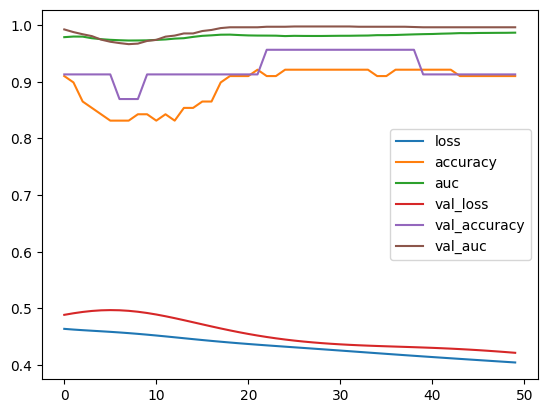

In [60]:
# plot the metrics
history_callback = model.fit(X_train, train_labels, batch_size = 128, 
                             epochs = 50, verbose = 0, validation_split = .2)
pd.DataFrame(history_callback.history).plot() 

The first MLP model above achieved an accuracy at the multiclass classification problem of 0.86 with an AUC of 0.97 when evaluated on the test data. 


Next, for the second portion of Part II, I will build and compare two separate MLP models with different numbers of hidden layers and hidden neurons. Similar to above, I also score each of the models on multiple metrics including loss, accuracy, and AUC. 

The first MLP that I build below for comparison will have three hidden layers, each with 24 neurons. 

In [13]:
# model 2
model2 = Sequential([ 
    Dense(24, input_shape = (4, )), # input and hidden layer
    Activation('relu'), 
    Dense(24), # hidden layer 2
    Activation('relu'), 
    Dense(24), # hidden layer 3
    Activation('relu'),
    Dense(3), # three categories to predict
    Activation('softmax')])

model2.summary() 

# compile with cat crossentropy for multiple DV classes
model2.compile("adam", "categorical_crossentropy", 
              metrics = ["accuracy", "AUC"])

# train the model with validation
model2.fit(X_train, train_labels, 
    batch_size = 32, epochs = 50, verbose = 0, validation_split = 0.1)

# evalute test data
score2 = model2.evaluate(X_test, test_labels, verbose = 0)
print("Model 2 Test loss:{:.3f}".format(score2[0]))
print("Model 2 Test Accuracy:{:.3f}".format(score2[1])) 
print("Model 2 Test AUC:{:.3f}".format(score2[2])) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 24)                120       
                                                                 
 activation_10 (Activation)  (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 24)                600       
                                                                 
 activation_11 (Activation)  (None, 24)                0         
                                                                 
 dense_12 (Dense)            (None, 24)                600       
                                                                 
 activation_12 (Activation)  (None, 24)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                

<Axes: >

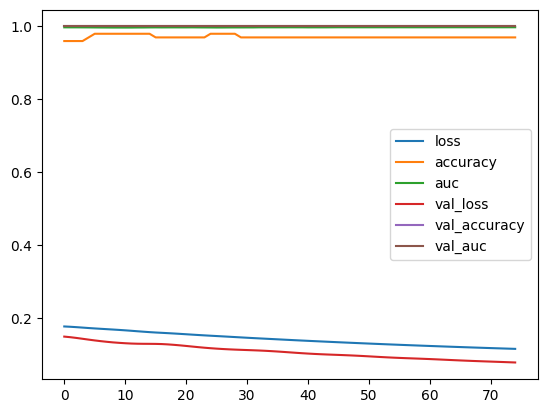

In [14]:
# plot the metrics 
history_callback = model2.fit(X_train, train_labels, batch_size = 128, 
                             epochs = 50, verbose = 0, validation_split = .1)
pd.DataFrame(history_callback.history).plot() 

We can see that the AUC on the test data was even higher for this MLP than the first MLP tested above. Additionally, the AUC improved. 

Finally, I will fit an MLP with 1 hidden layer that has 16 neurons. I am curious to test a model with fewer parameters (nearly 1/10th the number of parameters as the model above). However, for this MLP, I will also increase the number of training cycles (epochs) to 100 to see if a simpler model can outpeform the more complex one above with twice the number of training cycles. 

In [15]:
# model 3
model3 = Sequential([ 
    Dense(16, input_shape = (4, )), # input and 1 hidden layer
    Activation('relu'), 
    Dense(3), # three categories to predict
    Activation('softmax')])

# model summary 
model3.summary()
# compile with cat crossentropy for multiple DV classes
model3.compile("adam", "categorical_crossentropy", 
              metrics = ["accuracy", "AUC"])

# train the model with validation
model3.fit(X_train, train_labels, 
    batch_size = 32, epochs = 100, verbose = 0, validation_split = 0.1)

# evalute test data
score3 = model3.evaluate(X_test, test_labels, verbose = 0)
print("Model 3 Test loss:{:.3f}".format(score3[0]))
print("Model 3 Test Accuracy:{:.3f}".format(score3[1])) 
print("Model 3 Test AUC:{:.3f}".format(score3[2])) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                80        
                                                                 
 activation_14 (Activation)  (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 3)                 51        
                                                                 
 activation_15 (Activation)  (None, 3)                 0         
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Model 3 Test loss:0.573
Model 3 Test Accuracy:0.816
Model 3 Test AUC:0.969


<Axes: >

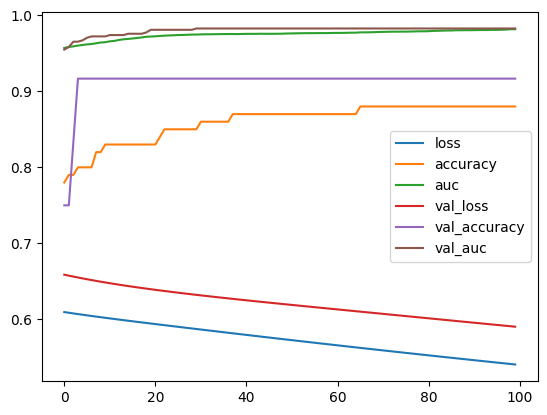

In [16]:
# plot the metrics 
history_callback = model3.fit(X_train, train_labels, batch_size = 128, 
                             epochs = 100, verbose = 0, validation_split = .1)
pd.DataFrame(history_callback.history).plot() 

The results for the third MLP model showed that it classified the iris species less well on the test data than the second, more complex model. Moreover, AUC for this third model was more simple. 

Thus, the second MLP model, which had three hidden layers and significanlty more parameters than the other two models test, demonstrated the greatest level of predictive accuracy, even with half the number of training cycles than the more simple model possessed. 